# Hydrogen molecule dissociation via Configuratin Interaction 


In [ ]:
# Required imports
import matplotlib.pyplot as plt
import numpy as np
import scipy as sp
from basistool import compute_integrals
from tqdm import tqdm



In [236]:
BOHR_TO_ANGSTROM = 0.52917721092


In [184]:
# Integrals
margin = 2.0 
dists = np.geomspace(0.7, 8.0, 40) 
datas = []
for dist in tqdm(dists):
    zgrid = np.arange(-dist / 2 - margin, dist / 2 + margin, 0.02)
    points = np.zeros((len(zgrid), 3))
    points[:, 2] = zgrid
    data = compute_integrals(
        ["H", "H"], [[0.0, 0.0, -dist / 2], [0.0, 0.0, dist / 2]], "aug-cc-pvdz.gbs", points
    )
    datas.append(data)

100%|██████████| 40/40 [00:34<00:00,  1.15it/s]


In the following cell, all lines that end with a `# RHF` comment contain RHF-specific code.

In [ ]:
def solve_rhf():
    for dist, data in zip(tqdm(dists), datas, strict=False):
        # Get a few operators.
        coreham = data["kei"] + data["nai"]
        eri = data["eri"]
        olp = data["oi"]
        data["hcore"] = coreham
        
        # The initial guess.
        eigvals, eigvecs = sp.linalg.eigh(coreham, olp)
        dm = np.dot(eigvecs[:, :1], eigvecs[:, :1].T)  # RHF

        # The scf cycle (See 02_helium.ipynb for details.)
        for _scf_counter in range(1000):
            hartree = np.einsum("kmln,nm->kl", eri, dm)
            exchange = np.einsum("kmnl,nm->kl", eri, dm)
            fock = coreham + 2 * hartree - exchange  # Specific for RHF

            errors_rh = np.dot(fock, eigvecs) - np.einsum("ij,jk,k->ik", olp, eigvecs, eigvals)
            error_rh = np.linalg.norm(errors_rh)  # Frobenius norm
            if error_rh < 1e-7:
                break

            eigvals, eigvecs = sp.linalg.eigh(fock, olp)
            dm = np.dot(eigvecs[:, :1], eigvecs[:, :1].T)
        else:
            raise RuntimeError("SCF convergence failed")

        # Compute the _electronic_ energy.
        ham = coreham + hartree - 0.5 * exchange  #  RHF
        electronic_energy = 2 * np.einsum("ij,ji", ham, dm)  # RHF

        # Compute the occupied orbital on the grid.
        psi0 = np.dot(eigvecs[:, 0], data["bfs"])  # RHF
        psi1 = np.dot(eigvecs[:, 1], data["bfs"])  # RHF

        # Store results back into the data dictionary.
        # (Mind the two electrons.)
        data["eigvals_rhf"] = eigvals
        data['eigvecs_rhf'] = eigvecs
        data["energy_rhf"] = electronic_energy + 1 / dist
        data["density0_rhf"] = 2 * psi0**2  # RHF waarom factor 2
        data["density1_rhf"] = psi1 ** 2 #waarom was psi 1 niet erbij gedaan?
        data["density_rhf"] = psi0**2 + psi1**2

solve_rhf()

100%|██████████| 40/40 [00:00<00:00, 308.22it/s]


In the following cell, all lines that end with a `# UHF` comment contain UHF-specific code.

In [251]:
def solve_ufh():
    for dist, data in zip(tqdm(dists), datas, strict=False):
        # Get a few operators.
        coreham = data["kei"] + data["nai"]
        eri = data["eri"]
        olp = data["oi"]

        # The initial guess.
        eigvals, eigvecs = sp.linalg.eigh(coreham, olp)
        dm = np.dot(eigvecs[:, :2], eigvecs[:, :2].T)  # UHF (2 alphas)

        # The SCF cycle (See 02_helium.ipynb for details.)
        for _scf_counter in range(500):
            hartree = np.einsum("kmln,nm->kl", eri, dm)
            exchange = np.einsum("kmnl,nm->kl", eri, dm)
            fock = coreham + hartree - exchange  # UHF

            errors_rh = np.dot(fock, eigvecs) - np.einsum("ij,jk,k->ik", olp, eigvecs, eigvals)
            error_rh = np.linalg.norm(errors_rh)  # Frobenius norm
            if error_rh < 1e-7:
                break

            eigvals, eigvecs = sp.linalg.eigh(fock, olp)
            dm = np.dot(eigvecs[:, :2], eigvecs[:, :2].T)
        else:
            raise RuntimeError("SCF convergence failed")

        # Compute the _electronic_ energy.
        ham = coreham + 0.5 * hartree - 0.5 * exchange  # UHF
        electronic_energy = np.einsum("ij,ji", ham, dm)  # UHF

        # Compute the occupied orbitals on the grid.
        psi0 = np.dot(eigvecs[:, 0], data["bfs"])  # UHF
        psi1 = np.dot(eigvecs[:, 1], data["bfs"])  # UHF

        # Store the energy. The second term in the energy is the nucleus-nucleus
        # repulsion.
        data["eigvecs_uhf"] = eigvecs
        data["eigvals_uhf"] = eigvals
        data["energy_uhf"] = electronic_energy + 1 / dist
        data["density_uhf"] = psi0**2 + psi1**2
        data["density0_uhf"] = psi0**2
        data["density1_uhf"] = psi1**2


solve_ufh()

100%|██████████| 40/40 [00:00<00:00, 205.00it/s]


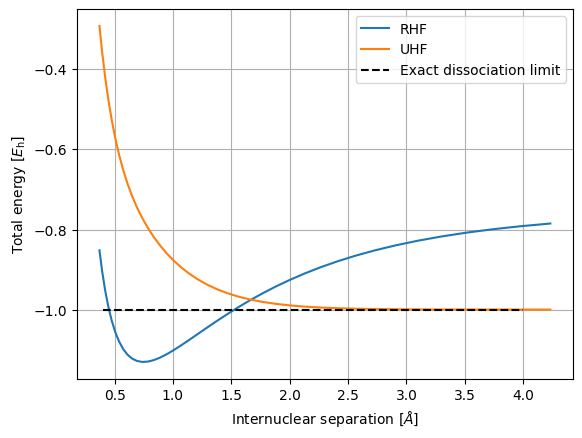

In [259]:
#convert distances from bohr to angstrom
def plot_energy(datas=datas, dists=dists):
    dists_ang = dists * BOHR_TO_ANGSTROM  # to angstrom
    plt.close("dissoc")
    _fig, ax = plt.subplots(num="dissoc")
    ax.plot(dists_ang, [data["energy_rhf"] for data in datas], label="RHF")
    ax.plot(dists_ang, [data["energy_uhf"] for data in datas], label="UHF")
    ax.hlines(-1.0, 0.4, 4, color="k", ls="--", label="Exact dissociation limit")
    ax.grid()
    ax.set_xlabel(r"Internuclear separation [$Å$]")
    ax.set_ylabel(r"Total energy [$E_\mathrm{h}$]")
    ax.legend()


plot_energy()

In [188]:
def analyze_equilibrium_orbitals(datas):
    """
    Find equilibrium geometry and analyze bonding/antibonding MOs.
    Returns dict with MO data and prints qualitative checks. 
    """
    keq = int(np.argmin([d["energy_rhf"] for d in datas]))
    data = datas[keq]
    C = data["eigvecs_rhf"]
    bfs = data["bfs"]
    
    psi0 = C[:, 0] @ bfs  # bonding (σg)
    psi1 = C[:, 1] @ bfs  # antibonding (σu)
    
    mid_idx = np. argmin(np. abs(data["points"][: , 2]))
    
    print(f"Equilibrium index: {keq}")
    print(f"psi0 (σg) midpoint value: {psi0[mid_idx]:.6f}")
    print(f"psi1 (σu) midpoint value: {psi1[mid_idx]:.6f}")
    
    return {
        "keq": keq,
        "data": data,
        "psi0": psi0,
        "psi1": psi1,
        "mid_idx": mid_idx,
    }

Equilibrium index: 11
psi0 (σg) midpoint value: 0.361814
psi1 (σu) midpoint value: 0.000257


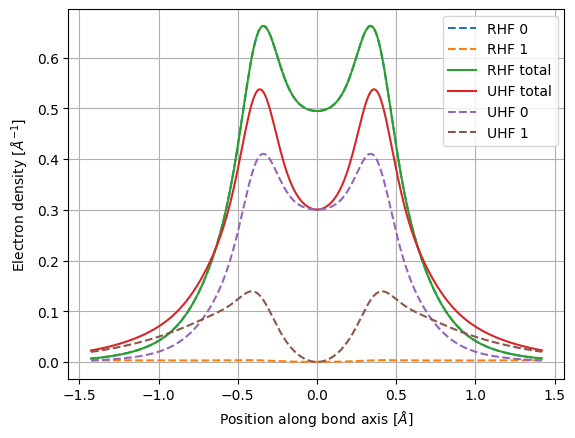

In [256]:
def plot_density():
    plt.close("density")
    fig, ax = plt.subplots(num="density")
    keq = analyze_equilibrium_orbitals(datas)["keq"]
    data = datas[keq]
    zgrid = data["points"][:, 2] * BOHR_TO_ANGSTROM  # to angstrom

    ax.plot(zgrid, data["density0_rhf"] / BOHR_TO_ANGSTROM, "--", label="RHF 0")
    ax.plot(zgrid, data["density1_rhf"]/ BOHR_TO_ANGSTROM, "--", label="RHF 1")
    ax.plot(zgrid, data["density_rhf"]/ BOHR_TO_ANGSTROM, label="RHF total")
    ax.plot(zgrid, data["density_uhf"]/ BOHR_TO_ANGSTROM, label="UHF total")
    ax.plot(zgrid, data["density0_uhf"]/ BOHR_TO_ANGSTROM, "--", label="UHF 0")
    ax.plot(zgrid, data["density1_uhf"]/ BOHR_TO_ANGSTROM, "--", label="UHF 1")
    ax.grid()
    ax.set_xlabel(r"Position along bond axis [$Å$]")
    ax.set_ylabel(r"Electron density [$Å^{-1}$]")
    ax.legend()
plot_density()

In [189]:
result_equilibrium = analyze_equilibrium_orbitals(datas)
keq = result_equilibrium["keq"]
data_eq = result_equilibrium["data"]
psi0_eq = result_equilibrium["psi0"]
psi1_eq = result_equilibrium["psi1"]
mid_idx = result_equilibrium["mid_idx"]

Equilibrium index: 11
psi0 (σg) midpoint value: 0.361814
psi1 (σu) midpoint value: 0.000257


In [190]:
def ao_to_mo_2orb(data, rfh=True):
    """
    Function to change between the basis consisting of basis functions (b_i) and the basis consisting
    of molecular orbitals (MO). We only keep the 2 MO with lowest energies, corresponding to the two
    sigma orbitals
    ----------
    Parameters
    ----------
    data : dict
        Dictionary containing the data we need (integrals, basis functions, ...)
    rfh : bool
        Boolean value that is True if we look at CI using RHF. If False, calculations are based on UHF.
    ----------
    returns
        h, g : np.array(2,2), np.aray(18,18,18,18)
            h is the core Hamiltonian H_kl = T_kl + V_ext_kl
            g is the electron repulsion integral V_ee_ijkl
    """
    if rfh: 
        C = data["eigvecs_rhf"][:, :2]   # keep 2 lowest MOs (18,2) (bonding and antibonding MO)
    else:
        C = data["eigvecs_uhf"][:, :2]   # keep 2 lowest MOs (18,2) (bonding and antibonding MO)

    h_ao = data["hcore"] #(18,18)
    eri_ao = data["eri"]  
    h = C.T @ h_ao @ C #(2,2) = (2,18) * (18,18) * (18,2), core hamiltonian
    g = np.einsum("pqrs,pi,qj,rk,sl->ijkl", eri_ao, C, C, C, C, optimize=True) #eri_MO (2,2,2,2) because only 2 lowest MO
    return h, g

h, g = ao_to_mo_2orb(data)

In [200]:
def ci_block_singlet_2orb(h, g, verbose=False):
    h00, h11 = h[0,0], h[1,1]
    h01 = h[0,1]

    g0000 = g[0,0,0,0]
    g1111 = g[1,1,1,1]
    g0011 = g[0,0,1,1]
    g0110 = g[0,1,1,0]
    g0101 = g[0,1,0,1]
    g0001 = g[0,0,0,1]
    g0111 = g[0,1,1,1]

    if verbose:
        print(f"h01 = {h01:.6f}, g0001 = {g0001:.6f}, sum = {h01 + g0001:.6f}")
        print(f"(Should be ~0 by Brillouin's theorem for canonical HF orbitals)")

    #diagonal elements of CI hamiltonian
    H = np.zeros((3, 3))
    H[0,0] = 2*h00 + g0000                              #Ground config energy
    H[1,1] = h00 + h11 + g0101                          #Singlet single-excitation energy
    H[2,2] = 2*h11 + g1111                              #Doubly-excited config energy    

    #off-diagonal elements of CI hamiltonian
    H[0,1] = H[1,0] = np. sqrt(2) * (h01 + g0001)       #Coupling between ground and single-excited config (≈0 by Brillouin)
    H[1,2] = H[2,1] = np. sqrt(2) * (h01 + g0111)       #Coupling between single- and doubly-excited config
    H[0,2] = H[2,0] = g0011                             #Coupling between ground and doubly-excited config  ! At large R, the key is H[0,2] = g₀₀₁₁ mixing |Φ₀⟩ and |Φ₂⟩:



    return H

def compute_ci_energy(h, g, dist, data, verbose=True):
    H = ci_block_singlet_2orb(h, g, verbose=verbose)
    eigvals, eigvecs = np.linalg. eigh(H)
    E_elec = eigvals[0]
    E_nuc = 1.0 / dist
    E_tot = E_elec + E_nuc  
    
    # Compare CI reference energy (no correlation) to RHF
    E_ci_ref = H[0,0] + E_nuc  # CI |0,0⟩ state energy
    
    print("CI Hamiltonian matrix (Ha):\n", H)
    print(f"H[0,0] + V_nuc (CI ref):    {E_ci_ref:.8f}")
    print(f"RHF total energy:            {data['energy_rhf']:.8f}")
    print(f"Difference (should be ~0):  {E_ci_ref - data['energy_rhf']:.2e}")
    print(f"CI ground-state energy:     {E_tot:.8f}")
    
    return {"H": H, "eigvals": eigvals, "eigvecs": eigvecs, "E_elec": E_elec, "E_tot": E_tot}

In [201]:
compute_ci_energy(h, g, dists[keq], data_eq, verbose=True)

h01 = -0.000000, g0001 = 0.000000, sum = -0.000000
(Should be ~0 by Brillouin's theorem for canonical HF orbitals)
CI Hamiltonian matrix (Ha):
 [[-1.84733706e+00 -2.71717649e-16  5.33982770e-03]
 [-2.71717649e-16 -1.36506173e+00 -4.86055752e-14]
 [ 5.33982770e-03 -4.86055752e-14 -4.26363171e-01]]
H[0,0] + V_nuc (CI ref):    -1.12872587
RHF total energy:            -1.12872587
Difference (should be ~0):  1.33e-15
CI ground-state energy:     -1.12874593


{'H': array([[-1.84733706e+00, -2.71717649e-16,  5.33982770e-03],
        [-2.71717649e-16, -1.36506173e+00, -4.86055752e-14],
        [ 5.33982770e-03, -4.86055752e-14, -4.26363171e-01]]),
 'eigvals': array([-1.84735712, -1.36506173, -0.4263431 ]),
 'eigvecs': array([[-9.99992940e-01,  9.82087520e-18, -3.75778517e-03],
        [-1.84571453e-16,  1.00000000e+00,  5.17360339e-14],
        [ 3.75778517e-03,  5.17363929e-14, -9.99992940e-01]]),
 'E_elec': np.float64(-1.8473571211734674),
 'E_tot': np.float64(-1.1287459323072473)}

In [202]:
h, g = ao_to_mo_2orb(data_eq, True)
result = compute_ci_energy(h, g, dists[keq], data_eq)

h01 = -0.000000, g0001 = 0.000000, sum = -0.000000
(Should be ~0 by Brillouin's theorem for canonical HF orbitals)
CI Hamiltonian matrix (Ha):
 [[-1.84733706e+00 -2.71717649e-16  5.33982770e-03]
 [-2.71717649e-16 -1.36506173e+00 -4.86055752e-14]
 [ 5.33982770e-03 -4.86055752e-14 -4.26363171e-01]]
H[0,0] + V_nuc (CI ref):    -1.12872587
RHF total energy:            -1.12872587
Difference (should be ~0):  1.33e-15
CI ground-state energy:     -1.12874593


In [238]:
keq = np.argmin([d["energy_rhf"] for d in datas])
# Get equilibrium distance
r_eq_bohr = dists[keq]
r_eq_ang = r_eq_bohr * BOHR_TO_ANGSTROM
min_energy = datas[keq]["energy_rhf"]

In [245]:
def compute_and_plot_correlation_energy(dists, datas, save_path="correlation_energy.png"):
    """
    Compute correlation energy (E_CI - E_HF) for all distances and plot. 
    Returns dict with energy arrays. 
    """
    E_rhf, E_uhf, E_ci_rhf, E_ci_uhf = [], [], [], []
    dists_ang = dists * BOHR_TO_ANGSTROM  # to angstrom

    for R, data in zip(dists, datas, strict=False):
        E_rhf.append(data["energy_rhf"])
        E_uhf. append(data["energy_uhf"])

        h_rhf, g_rhf = ao_to_mo_2orb(data)
        h_uhf, g_uhf = ao_to_mo_2orb(data, False)

        H_rhf = ci_block_singlet_2orb(h_rhf, g_rhf)
        H_uhf = ci_block_singlet_2orb(h_uhf, g_uhf)

        eigvals_rhf, _ = np.linalg. eigh(H_rhf)
        eigvals_uhf, _ = np.linalg.eigh(H_uhf)

        E_ci_rhf.append(eigvals_rhf[0] + 1.0 / R)
        E_ci_uhf. append(eigvals_uhf[0] + 1.0 / R)

    E_rhf, E_uhf = np.array(E_rhf), np.array(E_uhf)
    E_ci_rhf, E_ci_uhf = np.array(E_ci_rhf), np.array(E_ci_uhf)

    # Correlation energy = E_CI - E_HF (always negative)
    E_corr_rhf = E_ci_rhf - E_rhf
    E_corr_uhf = E_ci_uhf - E_uhf

    # Print values at key geometries
    print("Correlation Energy (E_CI - E_HF) in Hartree:")
    print("-" * 60)
    print(f"{'R (Å)':>10} {'E_corr(RHF)':>15} {'E_corr(UHF)':>15}")
    print("-" * 60)
    for i in [0, len(dists_ang)//4, len(dists_ang)//2, 3*len(dists_ang)//4, -1]:
        print(f"{dists_ang[i]:>10.3f} {E_corr_rhf[i]: >15.6f} {E_corr_uhf[i]:>15.6f}")
    print("-" * 60)

    # Plot
    fig, axes = plt.subplots(1, 2, figsize=(14, 5))

    # Left plot: Total energies
    axes[0].plot(dists_ang, E_rhf, label="RHF", lw=2)
    axes[0].set_xlim(0.4, 4.0)
    axes[0].set_ylim(-1.2, -0.5)
    r_eq_ang = dists_ang[np.argmin(E_rhf)]
    axes[0].axvline(r_eq_ang, color='red', ls='--', alpha=0.5, label=f'R_eq = {r_eq_ang:.2f} Å')
    axes[0].plot(dists_ang, E_ci_rhf, label="CI (RHF MOs)", lw=2, ls="--")
    axes[0].plot(dists_ang, E_uhf, label="UHF", lw=2)
    axes[0].plot(dists_ang, E_ci_uhf, label="CI (UHF MOs)", lw=2, ls="--")
    axes[0].axhline(-1.0, color="gray", ls=":", label="2 H atoms limit")
    axes[0].set_xlabel("H–H distance ( Å)")
    axes[0].set_ylabel("Energy (Hartree)")
    axes[0].set_title("Total Energies")
    axes[0].legend()
    axes[0].grid(True, ls="--", alpha=0.5)

    # Right plot: Correlation energy
    axes[1].plot(dists_ang, E_corr_rhf, label="E_corr (E_CI_RHF - E_RHF)", lw=2, color="C0")
    axes[1].plot(dists_ang, E_corr_uhf, label="E_corr (E_CI_UHF - E_UHF)", lw=2, color="C2")
    axes[1].set_xlim(0.4, 4.0)
    axes[1].set_ylim(-0.1, 0.05)
    axes[1].axhline(0, color="gray", ls=":")
    axes[1].set_xlabel("H–H distance ( Å)")
    axes[1].set_ylabel("Correlation Energy (Hartree)")
    axes[1].set_title("Correlation Energy:  E_CI - E_HF")
    axes[1].legend()
    axes[1].grid(True, ls="--", alpha=0.5)

    plt.tight_layout()
    plt.savefig(save_path, dpi=200)
    plt.show()

    # Find equilibrium and print detailed info
    keq = np.argmin(E_rhf)
    print(f"\nAt equilibrium (R = {dists[keq]*BOHR_TO_ANGSTROM:.3f}Å ):")
    print(f"  E_RHF      = {E_rhf[keq]:.8f} Ha")
    print(f"  E_CI(RHF)  = {E_ci_rhf[keq]:.8f} Ha")
    print(f"  E_corr     = {E_corr_rhf[keq]:.8f} Ha ({E_corr_rhf[keq]*27.2114:.4f} eV)")

    print(f"\nAt dissociation (R = {dists_ang[-1]*BOHR_TO_ANGSTROM:.3f} Å):")
    print(f"  E_RHF      = {E_rhf[-1]:.8f} Ha")
    print(f"  E_CI(RHF)  = {E_ci_rhf[-1]:.8f} Ha")
    print(f"  E_corr     = {E_corr_rhf[-1]:.8f} Ha ({E_corr_rhf[-1]*27.2114:.4f} eV)")

    return {
        "E_rhf": E_rhf, 
        "E_uhf": E_uhf, 
        "E_ci_rhf": E_ci_rhf, 
        "E_ci_uhf": E_ci_uhf,
        "E_corr_rhf":  E_corr_rhf,
        "E_corr_uhf": E_corr_uhf,
    }

Correlation Energy (E_CI - E_HF) in Hartree:
------------------------------------------------------------
     R (Å)     E_corr(RHF)     E_corr(UHF)
------------------------------------------------------------
     0.370       -0.000032       -0.520066
     0.692       -0.000014       -0.362084
     1.292       -0.002570       -0.133023
     2.413       -0.091795       -0.008076
     4.233       -0.184551       -0.000030
------------------------------------------------------------


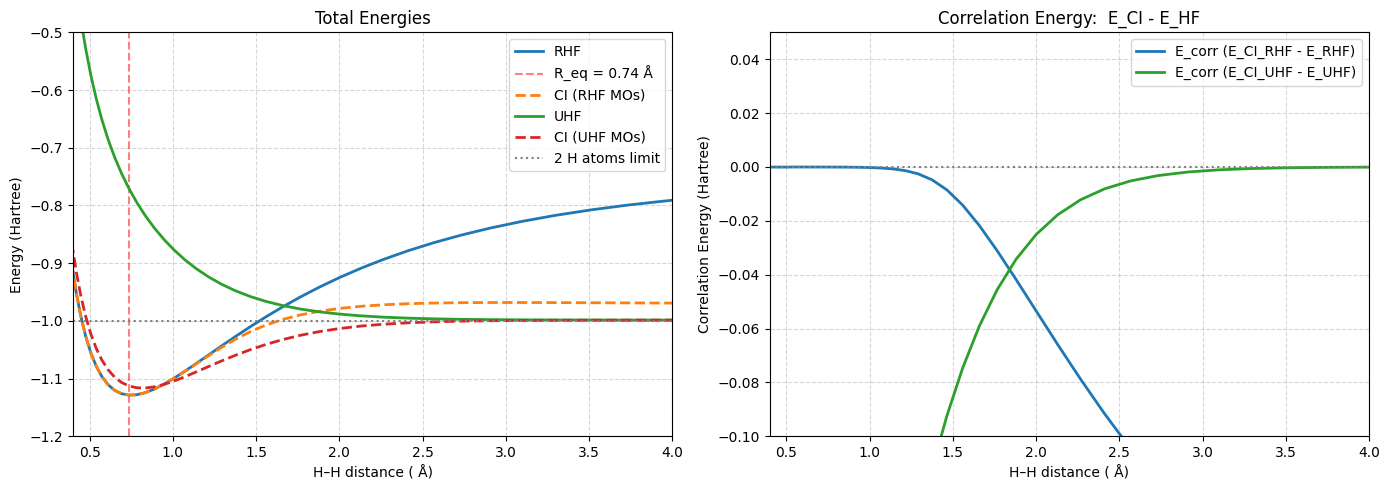


At equilibrium (R = 0.736Å ):
  E_RHF      = -1.12872587 Ha
  E_CI(RHF)  = -1.12874593 Ha
  E_corr     = -0.00002007 Ha (-0.0005 eV)

At dissociation (R = 2.240 Å):
  E_RHF      = -0.78486461 Ha
  E_CI(RHF)  = -0.96941542 Ha
  E_corr     = -0.18455081 Ha (-5.0219 eV)


In [246]:
result = compute_and_plot_correlation_energy(dists, datas)

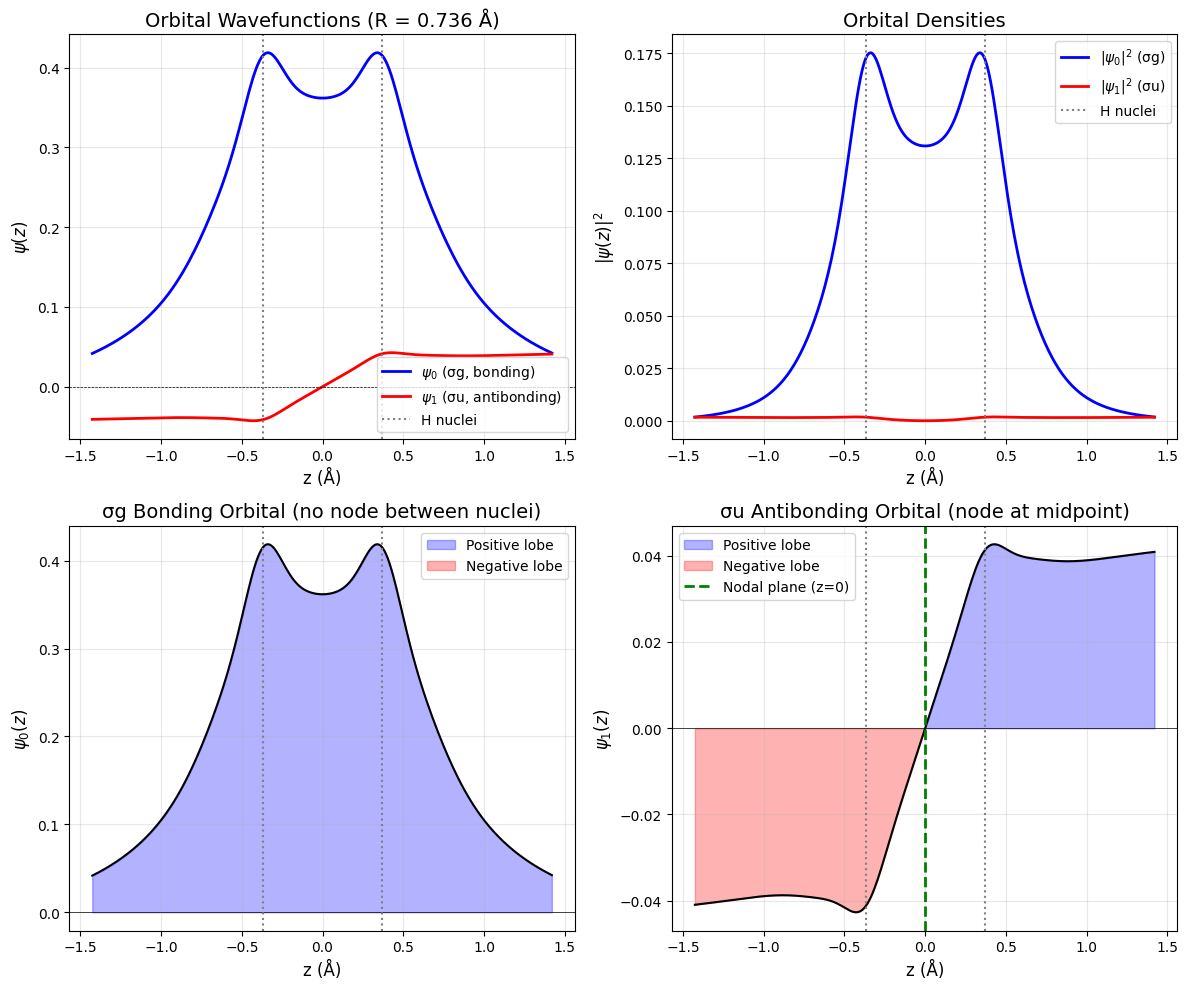


=== Orbital Symmetry Analysis ===
Internuclear distance:  0.7364 Å (1.3916 Bohr)

σg (bonding) orbital:
  - Value at midpoint (z=0): 0.361814
  - Symmetric (same sign on both sides): Yes

σu (antibonding) orbital:
  - Value at midpoint (z=0): 0.000257
  - Has node at midpoint:  Yes


In [264]:
import numpy as np
import matplotlib.pyplot as plt

# Conversion factor from Bohr to Angstrom
BOHR_TO_ANGSTROM = 0.529177249

# Choose equilibrium geometry index (minimum energy)
keq = int(np.argmin([d["energy_rhf"] for d in datas]))
data = datas[keq]
dist = dists[keq]

# Get MO coefficients and basis functions
C = data["eigvecs_rhf"]  # AO -> MO coefficients (columns = MOs)
bfs = data["bfs"]        # AO basis functions on grid points

# Convert z-coordinates to Angstroms
z_angstrom = data["points"][:, 2] * BOHR_TO_ANGSTROM
dist_angstrom = dist * BOHR_TO_ANGSTROM

# Build the two lowest spatial MOs on your grid
psi0 = C[:, 0] @ bfs  # σg (bonding orbital)
psi1 = C[:, 1] @ bfs  # σu (antibonding orbital)

# Calculate densities
rho0 = psi0**2
rho1 = psi1**2

# Create figure with subplots
fig, axes = plt.subplots(2, 2, figsize=(12, 10))

# Plot 1: Orbital wavefunctions (ψ)
ax1 = axes[0, 0]
ax1.plot(z_angstrom, psi0, 'b-', linewidth=2, label=r'$\psi_0$ (σg, bonding)')
ax1.plot(z_angstrom, psi1, 'r-', linewidth=2, label=r'$\psi_1$ (σu, antibonding)')
ax1.axhline(y=0, color='k', linestyle='--', linewidth=0.5)
ax1.axvline(x=-dist_angstrom/2, color='gray', linestyle=':', linewidth=1.5, label='H nuclei')
ax1.axvline(x=dist_angstrom/2, color='gray', linestyle=':', linewidth=1.5)
ax1.set_xlabel(r'z (Å)', fontsize=12)
ax1.set_ylabel(r'$\psi(z)$', fontsize=12)
ax1.set_title(f'Orbital Wavefunctions (R = {dist_angstrom:.3f} Å)', fontsize=14)
ax1.legend(loc='best')
ax1.grid(True, alpha=0.3)

# Plot 2: Orbital densities (|ψ|²)
ax2 = axes[0, 1]
ax2.plot(z_angstrom, rho0, 'b-', linewidth=2, label=r'$|\psi_0|^2$ (σg)')
ax2.plot(z_angstrom, rho1, 'r-', linewidth=2, label=r'$|\psi_1|^2$ (σu)')
ax2.axvline(x=-dist_angstrom/2, color='gray', linestyle=':', linewidth=1.5, label='H nuclei')
ax2.axvline(x=dist_angstrom/2, color='gray', linestyle=':', linewidth=1.5)
ax2.set_xlabel(r'z (Å)', fontsize=12)
ax2.set_ylabel(r'$|\psi(z)|^2$', fontsize=12)
ax2.set_title('Orbital Densities', fontsize=14)
ax2.legend(loc='best')
ax2.grid(True, alpha=0.3)

# Plot 3: Bonding orbital with nodal analysis
ax3 = axes[1, 0]
ax3.fill_between(z_angstrom, psi0, 0, where=(psi0 >= 0), 
                  color='blue', alpha=0.3, label='Positive lobe')
ax3.fill_between(z_angstrom, psi0, 0, where=(psi0 < 0), 
                  color='red', alpha=0.3, label='Negative lobe')
ax3.plot(z_angstrom, psi0, 'k-', linewidth=1.5)
ax3.axhline(y=0, color='k', linestyle='-', linewidth=0.5)
ax3.axvline(x=-dist_angstrom/2, color='gray', linestyle=':', linewidth=1.5)
ax3.axvline(x=dist_angstrom/2, color='gray', linestyle=':', linewidth=1.5)
ax3.set_xlabel(r'z (Å)', fontsize=12)
ax3.set_ylabel(r'$\psi_0(z)$', fontsize=12)
ax3.set_title(r'σg Bonding Orbital (no node between nuclei)', fontsize=14)
ax3.legend(loc='best')
ax3.grid(True, alpha=0.3)

# Plot 4: Antibonding orbital with nodal analysis
ax4 = axes[1, 1]
ax4.fill_between(z_angstrom, psi1, 0, where=(psi1 >= 0), 
                  color='blue', alpha=0.3, label='Positive lobe')
ax4.fill_between(z_angstrom, psi1, 0, where=(psi1 < 0), 
                  color='red', alpha=0.3, label='Negative lobe')
ax4.plot(z_angstrom, psi1, 'k-', linewidth=1.5)
ax4.axhline(y=0, color='k', linestyle='-', linewidth=0.5)
ax4.axvline(x=-dist_angstrom/2, color='gray', linestyle=':', linewidth=1.5)
ax4.axvline(x=dist_angstrom/2, color='gray', linestyle=':', linewidth=1.5)
ax4.axvline(x=0, color='green', linestyle='--', linewidth=2, label='Nodal plane (z=0)')
ax4.set_xlabel(r'z (Å)', fontsize=12)
ax4.set_ylabel(r'$\psi_1(z)$', fontsize=12)
ax4.set_title(r'σu Antibonding Orbital (node at midpoint)', fontsize=14)
ax4.legend(loc='best')
ax4.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('h2_orbital_symmetry.png', dpi=150, bbox_inches='tight')
plt.show()

# Print analysis
mid_idx = np.argmin(np.abs(data["points"][:, 2]))
print("\n=== Orbital Symmetry Analysis ===")
print(f"Internuclear distance:  {dist_angstrom:.4f} Å ({dist:.4f} Bohr)")
print(f"\nσg (bonding) orbital:")
print(f"  - Value at midpoint (z=0): {psi0[mid_idx]:.6f}")
print(f"  - Symmetric (same sign on both sides): {'Yes' if psi0[mid_idx] > 0.1 else 'No'}")
print(f"\nσu (antibonding) orbital:")
print(f"  - Value at midpoint (z=0): {psi1[mid_idx]:.6f}")
print(f"  - Has node at midpoint:  {'Yes' if abs(psi1[mid_idx]) < 0.01 else 'No'}")